In [1]:
from googleapiclient.discovery import build
import pandas as pd  
from IPython.display import JSON
from dateutil import parser

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud



[nltk_data] Error loading stopwords: <urlopen error [WinError 10054]
[nltk_data]     An existing connection was forcibly closed by the
[nltk_data]     remote host>
[nltk_data] Error loading punkt: <urlopen error [WinError 10054] An
[nltk_data]     existing connection was forcibly closed by the remote
[nltk_data]     host>


In [2]:
api_key = ''

In [3]:
channel_ids = [
    'UCnz-ZXXER4jOvuED5trXfEA',
    'UCuFsaE9KGP9YxuhNP4GNy2Q',
    'UCJQJAI7IjbLcpsjWdSzYz0Q',
    'UC8wZnXYK_CGKlBcZp-GxYPA',
]

In [4]:
api_service_name = "youtube"
api_version = "v3"


# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [5]:
# # THIS IS FOR USERNAME #

# def get_channel_stats(youtube, channel_ids):
#     request = youtube.channels().list(
#         part="snippet,contentDetails,statistics",
#         forUsername="GoogleDevelopers"
#     )
#     response = request.execute()

#     return response


In [6]:


def get_channel_stats(youtube, channel_ids):
    all_data = []
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    #loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalViews': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        all_data.append(data)
        
    return(pd.DataFrame(all_data))

In [7]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [8]:
channel_stats

,channelName,subscribers,views,totalViews,playlistId
0,NeuralNine,265000,18608930,636,UU8wZnXYK_CGKlBcZp-GxYPA
1,techTFQ,242000,12463962,98,UUnz-ZXXER4jOvuED5trXfEA
2,Thu Vu data analytics,169000,5494570,75,UUJQJAI7IjbLcpsjWdSzYz0Q
3,BLADE RUNNER,19,11530,38,UUuFsaE9KGP9YxuhNP4GNy2Q


In [9]:
playlist_id = "UUJQJAI7IjbLcpsjWdSzYz0Q"

def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()

    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
        
    next_page_token = response['nextPageToken']
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="contentDetails",
            playlistId=playlist_id,
            maxResults = 50,
            pageToken = next_page_token
        )
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
             
        next_page_token = response.get('nextPageToken')
        
    return video_ids

In [10]:
video_ids = get_video_ids(youtube, playlist_id)

In [11]:
len(video_ids)

75

In [12]:
def get_video_details(youtube, video_ids):

    all_video_info = []

    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {
                'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                            'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                            'contentDetails': ['duration', 'definition', 'caption']
            }
            video_info = {}
            video_info['video_id'] = video['id']
            for k in stats_to_keep.keys():
                    for v in stats_to_keep[k]:
                        try:
                            video_info[v] = video[k][v]
                        except:
                            video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)




In [13]:
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,uGynMyXCcg8,Thu Vu data analytics,Books to Learn about AI: You can’t miss these!!,Artificial Intelligence 👉 https://amzn.to/3tnh...,"[data analytics, data science, python, data, t...",2023-10-09T22:02:40Z,2830,284,None,6,PT59S,hd,false
1,EzVIkHQWnhc,Thu Vu data analytics,How to Handle Sensitive Data in Data Science (...,🏆 Check out Antigranular competition & win cas...,"[data analytics, data science, python, data, t...",2023-08-22T00:29:27Z,4772,241,None,29,PT12M19S,hd,false
2,8sLq4P-QDL0,Thu Vu data analytics,I Tried ChatGPT Code Interpreter for Data Task...,I tell ChatGPT Code Interpreter to do my job 😅...,"[data analytics, data science, python, data, t...",2023-07-15T19:02:17Z,34168,1594,None,50,PT58S,hd,false
3,3736Pd_hwFQ,Thu Vu data analytics,40 Productivity Tips that Make You More Pro in...,📩 Interested in hearing about my coming course...,"[data analytics, data science, python, data, t...",2023-07-08T09:45:30Z,12142,626,None,60,PT1H16M9S,hd,false
4,PvnSSrnjLX8,Thu Vu data analytics,Self-taught vs. Guided Program: CareerFoundry'...,📊 Enroll with this link to get 10% off the Dat...,"[data analytics, data science, python, data, t...",2023-06-16T22:57:31Z,7055,213,None,32,PT16M32S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,5LWoJAh-kww,Thu Vu data analytics,Data Analyst Skill Stack // How I Became A Dat...,👩🏻‍💻 My laptop and iPad for doing DS/ study 👉 ...,None,2021-06-16T10:16:47Z,32087,1776,None,72,PT10M35S,hd,false
71,_RzoHVWKwq4,Thu Vu data analytics,Effective visual note-taking on iPad + Downloa...,Hi there! In this video I’m showing you how to...,"[Note-taking, Study, iPad Pro, Visual note-tak...",2021-06-09T06:58:21Z,9530,341,None,10,PT8M19S,hd,false
72,hWKLO7GtpiU,Thu Vu data analytics,Data scientist is NOT the only SEXY job // All...,Hi there! In this video I explain different da...,None,2021-06-01T22:51:42Z,8415,287,None,20,PT14M4S,hd,false
73,dBZqggW22rs,Thu Vu data analytics,"How I take notes on iPad Pro | Notion, Notes, ...",My note-taking system tour in Notion and tips ...,"[Notes, Study, Productivity, Notion, Procreate...",2021-05-16T22:47:12Z,9894,251,None,18,PT9M7S,hd,false


In [14]:
def get_comments_in_videos(youtube, video_ids):
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)

In [15]:
comments_df = get_comments_in_videos(youtube, video_ids)
comments_df

,video_id,comments
0,uGynMyXCcg8,"[Hoping to find some time for 1 of these, @Thu..."
1,EzVIkHQWnhc,[Mam as a ms Excel export please clear my doub...
2,8sLq4P-QDL0,[I think 99% of us have no clue what the relea...
3,3736Pd_hwFQ,[What is your favourite tip and trick using da...
4,PvnSSrnjLX8,[My previous upload was cut off half way due t...
...,...,...
70,5LWoJAh-kww,[Hi Thu! Thank you for this valuable content. ...
71,_RzoHVWKwq4,"[Really helpful video. Just what I needed, 🙏🙏🙏..."
72,hWKLO7GtpiU,[@Thu Vu data analytics Hello Ms Thu Vu! Your ...
73,dBZqggW22rs,[How do you differentiate what notes you type ...


In [16]:
comments_df['comments'][0]

['Hoping to find some time for 1 of these',
 "@Thuvu5 ma'am can you do short overview of this books in next video?",
 'such a great video...',
 'Links to the books are in the short description! 😊']

## DATA PRE-PROCESSING

In [17]:
# Check for NULL values
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [18]:
# Check data types
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [19]:
# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [20]:
# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [21]:
# convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [22]:
video_df[['durationSecs', 'duration']] 

,durationSecs,duration
0,59.0,PT59S
1,739.0,PT12M19S
2,58.0,PT58S
3,4569.0,PT1H16M9S
4,992.0,PT16M32S
...,...,...
70,635.0,PT10M35S
71,499.0,PT8M19S
72,844.0,PT14M4S
73,547.0,PT9M7S


In [23]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [24]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagCount
0,uGynMyXCcg8,Thu Vu data analytics,Books to Learn about AI: You can’t miss these!!,Artificial Intelligence 👉 https://amzn.to/3tnh...,"[data analytics, data science, python, data, t...",2023-10-09 22:02:40+00:00,2830.0,284.0,NaN,6.0,PT59S,hd,false,Monday,59.0,23
1,EzVIkHQWnhc,Thu Vu data analytics,How to Handle Sensitive Data in Data Science (...,🏆 Check out Antigranular competition & win cas...,"[data analytics, data science, python, data, t...",2023-08-22 00:29:27+00:00,4772.0,241.0,NaN,29.0,PT12M19S,hd,false,Tuesday,739.0,23
2,8sLq4P-QDL0,Thu Vu data analytics,I Tried ChatGPT Code Interpreter for Data Task...,I tell ChatGPT Code Interpreter to do my job 😅...,"[data analytics, data science, python, data, t...",2023-07-15 19:02:17+00:00,34168.0,1594.0,NaN,50.0,PT58S,hd,false,Saturday,58.0,23
3,3736Pd_hwFQ,Thu Vu data analytics,40 Productivity Tips that Make You More Pro in...,📩 Interested in hearing about my coming course...,"[data analytics, data science, python, data, t...",2023-07-08 09:45:30+00:00,12142.0,626.0,NaN,60.0,PT1H16M9S,hd,false,Saturday,4569.0,23
4,PvnSSrnjLX8,Thu Vu data analytics,Self-taught vs. Guided Program: CareerFoundry'...,📊 Enroll with this link to get 10% off the Dat...,"[data analytics, data science, python, data, t...",2023-06-16 22:57:31+00:00,7055.0,213.0,NaN,32.0,PT16M32S,hd,false,Friday,992.0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,5LWoJAh-kww,Thu Vu data analytics,Data Analyst Skill Stack // How I Became A Dat...,👩🏻‍💻 My laptop and iPad for doing DS/ study 👉 ...,None,2021-06-16 10:16:47+00:00,32087.0,1776.0,NaN,72.0,PT10M35S,hd,false,Wednesday,635.0,0
71,_RzoHVWKwq4,Thu Vu data analytics,Effective visual note-taking on iPad + Downloa...,Hi there! In this video I’m showing you how to...,"[Note-taking, Study, iPad Pro, Visual note-tak...",2021-06-09 06:58:21+00:00,9530.0,341.0,NaN,10.0,PT8M19S,hd,false,Wednesday,499.0,4
72,hWKLO7GtpiU,Thu Vu data analytics,Data scientist is NOT the only SEXY job // All...,Hi there! In this video I explain different da...,None,2021-06-01 22:51:42+00:00,8415.0,287.0,NaN,20.0,PT14M4S,hd,false,Tuesday,844.0,0
73,dBZqggW22rs,Thu Vu data analytics,"How I take notes on iPad Pro | Notion, Notes, ...",My note-taking system tour in Notion and tips ...,"[Notes, Study, Productivity, Notion, Procreate...",2021-05-16 22:47:12+00:00,9894.0,251.0,NaN,18.0,PT9M7S,hd,false,Sunday,547.0,8


## EDA

### BEST PERFORMING VIDEOS

c:\Users\Hakeem\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 128105 (\N{WOMAN}) missing from current font.
  func(*args, **kwargs)
c:\Users\Hakeem\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 127995 (\N{EMOJI MODIFIER FITZPATRICK TYPE-1-2}) missing from current font.
  func(*args, **kwargs)
c:\Users\Hakeem\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 128187 (\N{PERSONAL COMPUTER}) missing from current font.
  func(*args, **kwargs)
c:\Users\Hakeem\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 129321 (\N{GRINNING FACE WITH STAR EYES}) missing from current font.
  func(*args, **kwargs)
c:\Users\Hakeem\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 128218 (\N{BOOKS}) missing from current font.
  func(*a

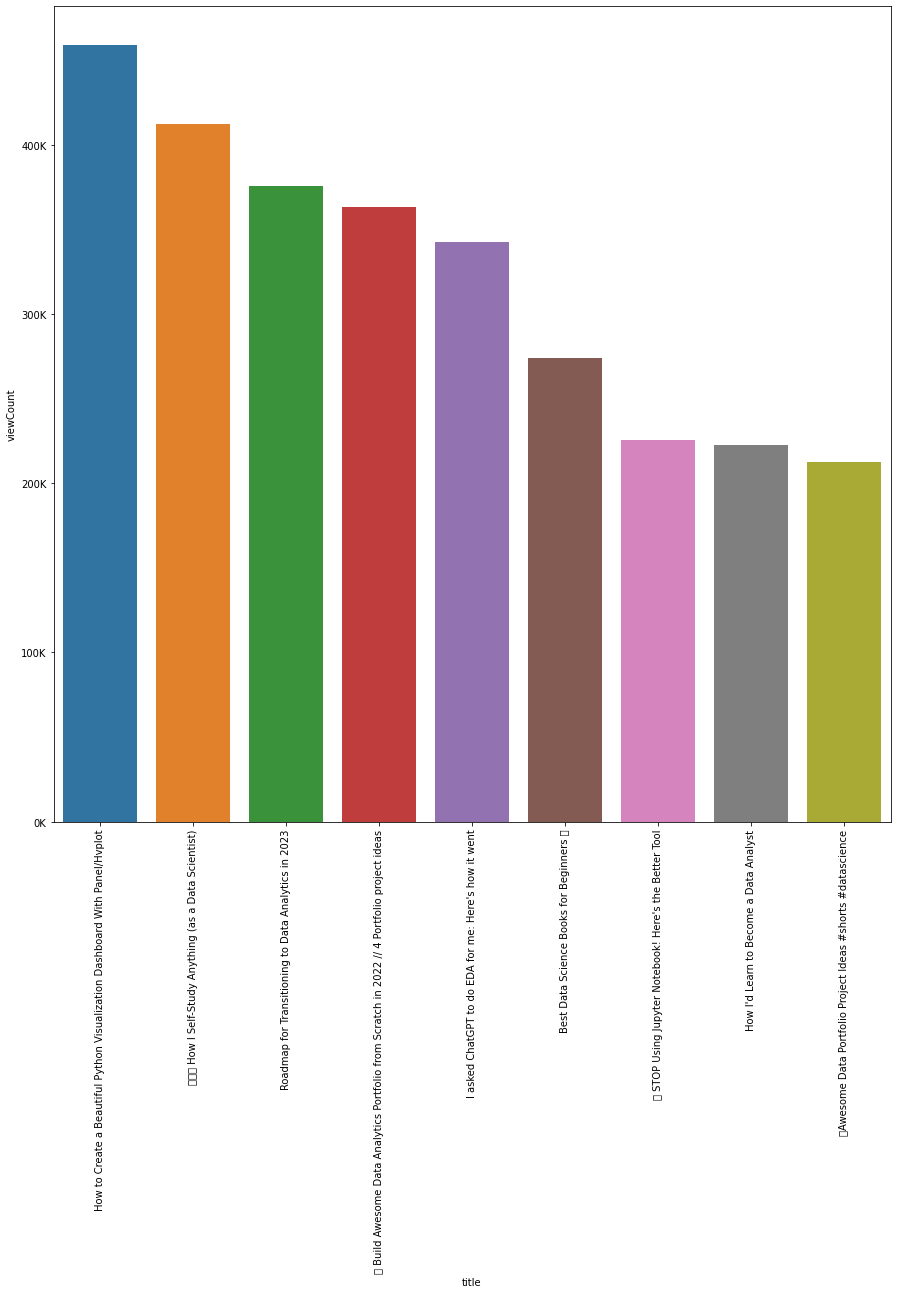

In [25]:
plt.figure(figsize=(15, 15))
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))


### WORST PERFORMING VIDEOS

c:\Users\Hakeem\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 128105 (\N{WOMAN}) missing from current font.
  func(*args, **kwargs)
c:\Users\Hakeem\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 128187 (\N{PERSONAL COMPUTER}) missing from current font.
  func(*args, **kwargs)
c:\Users\Hakeem\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 129299 (\N{NERD FACE}) missing from current font.
  func(*args, **kwargs)
c:\Users\Hakeem\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128105 (\N{WOMAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Hakeem\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128187 (\N{PERSONAL COMPUTER}) missing from current font.
  fig.canvas.print

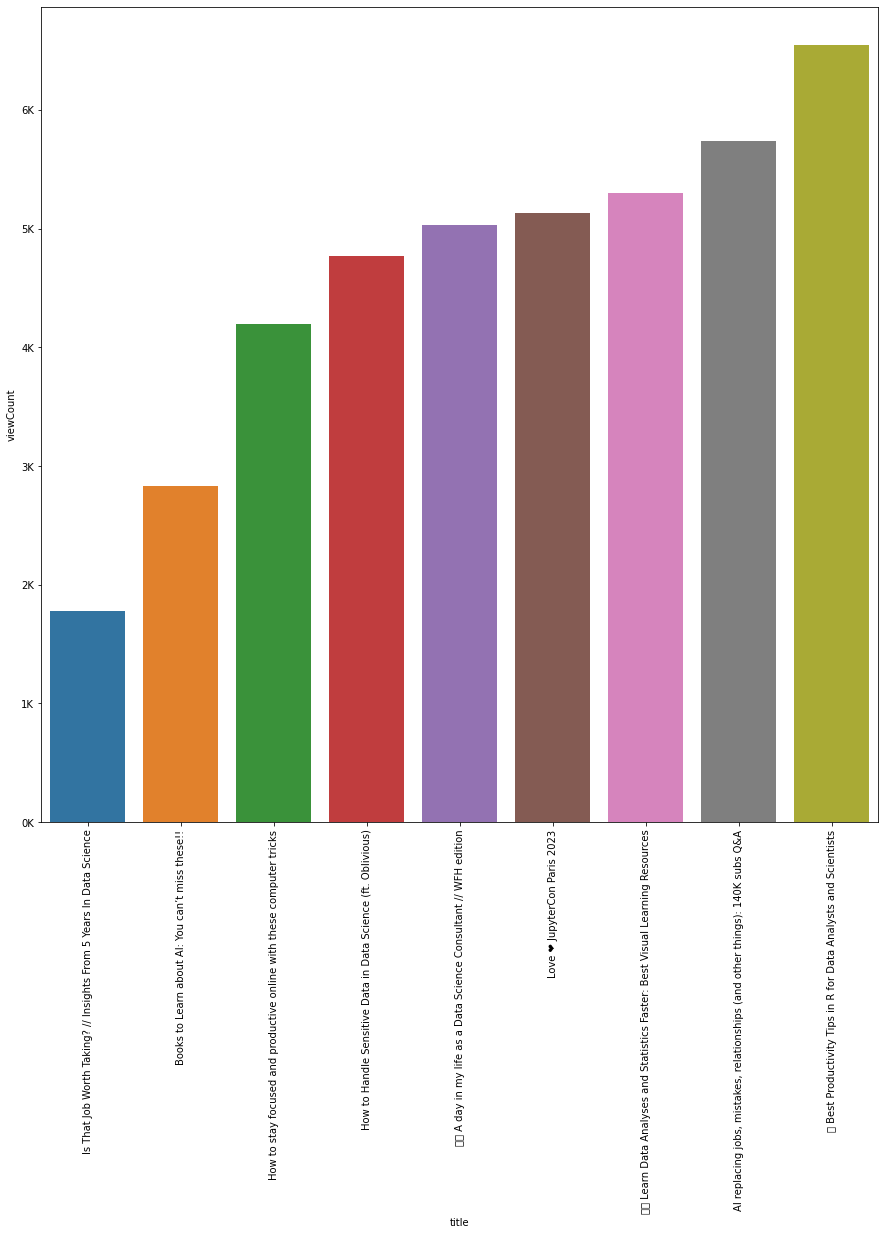

In [26]:
plt.figure(figsize=(15, 15))
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

### VIEW DISTRIBUTION PER VIDEO 

In [35]:
sns.violinplot(video_df['channelTitle'], video_df['viewCount'])

TypeError: violinplot() takes from 0 to 1 positional arguments but 2 were given

### VIEW VS LIKES & COMMENTS

<Axes: xlabel='likeCount', ylabel='viewCount'>

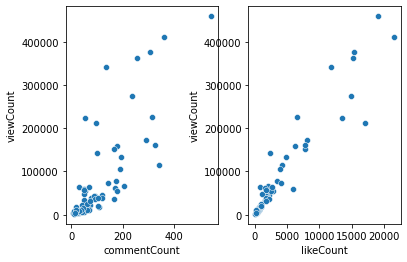

In [29]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

### VIDEO DURATION

<Axes: xlabel='durationSecs', ylabel='Count'>

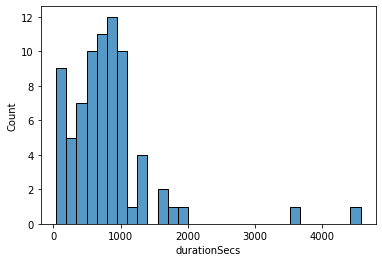

In [30]:
sns.histplot(data = video_df, x = 'durationSecs', bins=30)

### WORDCLOUD FOR VIDEO TITLES

In [31]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

ValueError: Only supported for TrueType fonts

### UPLOAD SCHEDULE

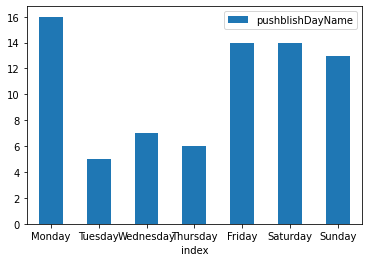

In [32]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)